In [120]:
import cv2
import numpy as np
from commonfunctions import *
import imutils

In [121]:
def unsharp_mask(image, sigma=1.0, strength=1.5):
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    # Subtract the blurred image from the original
    sharpened = cv2.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
    return sharpened

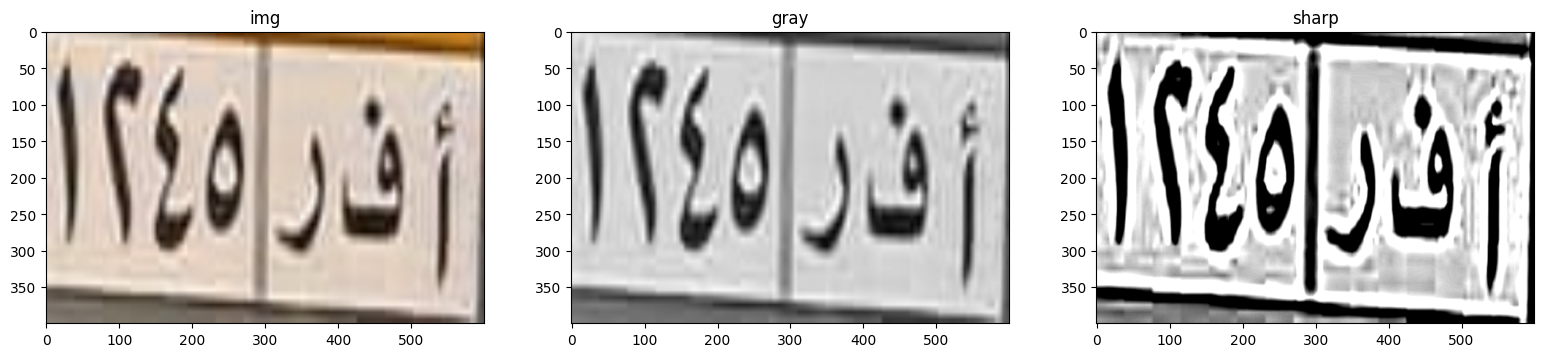

In [122]:
img = cv2.imread('Results3/0025.jpg', cv2.IMREAD_COLOR)
img = cv2.resize(img, (600, 400))
#contrast enhancement
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# gray = cv2.equalizeHist(gray)
# gray = cv2.GaussianBlur(gray, (5, 5), 10)
# gray = np.where(gray < 180, np.min(gray), gray)
sharp = unsharp_mask(gray,10,5)
show_images([img,gray,sharp], ['img','gray','sharp'])


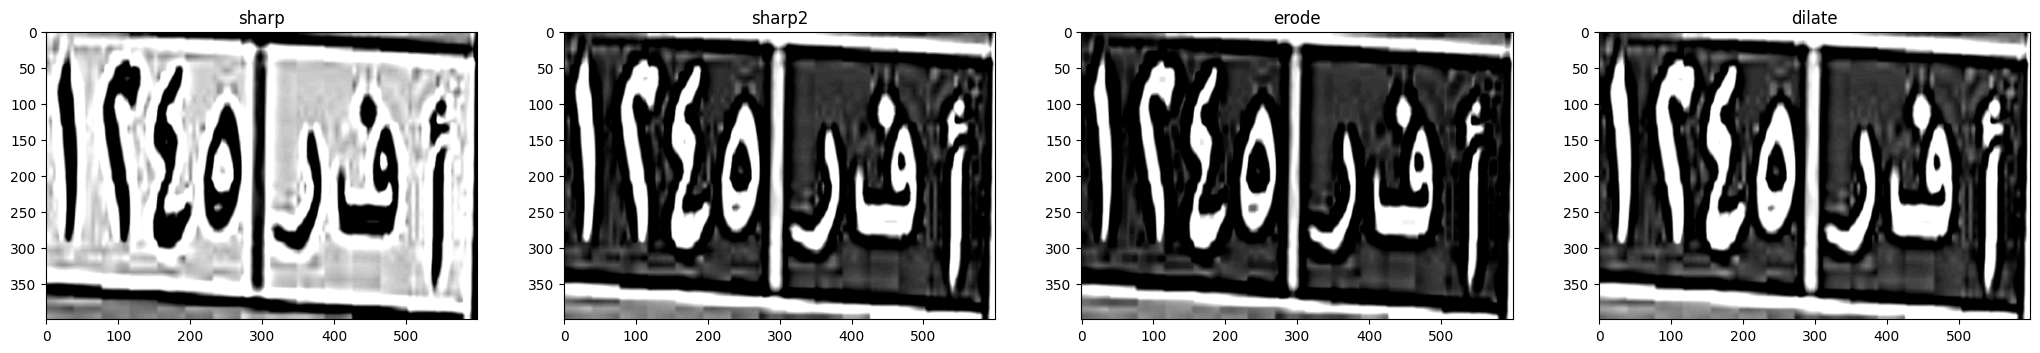

In [123]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 4))
sharp2 = cv2.bitwise_not(sharp)
erode = cv2.erode(sharp, rectKernel, iterations=1)
dilate = cv2.dilate(erode,(3,12), iterations=1)

#max filter
dilate = cv2.bitwise_not(dilate)
erode = cv2.erode(dilate, None, iterations=2)
show_images([sharp,sharp2,erode, dilate], ["sharp","sharp2","erode", "dilate"])

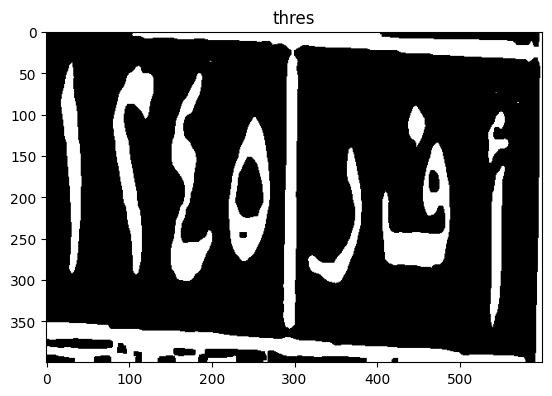

In [124]:
thresh = cv2.threshold(erode, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

show_images([thresh], ["thres"])

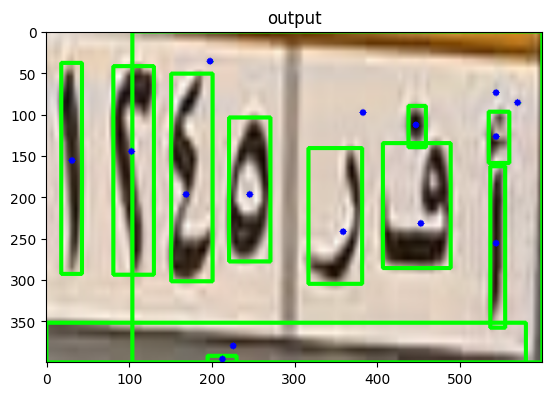

In [125]:
# get connected components and their stats
connectedComponents = cv2.connectedComponentsWithStats(
            thresh, 8, cv2.CV_32S)
(numLabels, labels, stats, centroids) = connectedComponents
output = img.copy()

for i in range(1, numLabels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]
    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
    cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)
show_images([output], ["output"])

In [126]:
def merge_vertical_rectangles(rectangles):
    merged_rectangles = rectangles.copy()
    for i in range(len(rectangles)):
            if merged_rectangles[i] is not None:
                #get centers
                # find if there is a rectangle just under it
                for j in range(i+1,len(rectangles)):
                    x1,y1,w1,h1 = merged_rectangles[i]
                    if merged_rectangles[j] is not None:
                        x2,y2,w2,h2 = merged_rectangles[j]
                        # get a larger rectangle that contains both
                        if (x1 <= x2 and x1+w1 >= x2) or (x1 >= x2 and x1 <= x2+w2):
                        
                            # merge the two rectangles
                            x1_new = min(x1,x2)
                            y1_new = min(y1,y2)
                            x2_new = max(x1+w1,x2+w2)
                            y2_new = max(y1+h1,y2+h2)
                            w_new = x2_new-x1_new
                            h_new = y2_new-y1_new
                            new_rect = (x1_new,y1_new,w_new,h_new)
                            new_aspect_ratio = w_new/h_new
                            if new_aspect_ratio < 0.6:
                                merged_rectangles[i] = new_rect
                                merged_rectangles[j] = None
    return merged_rectangles
    

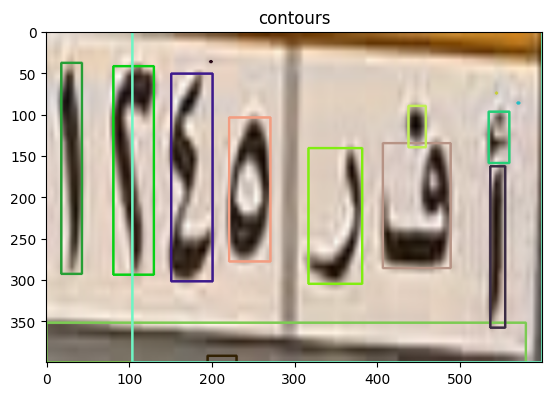

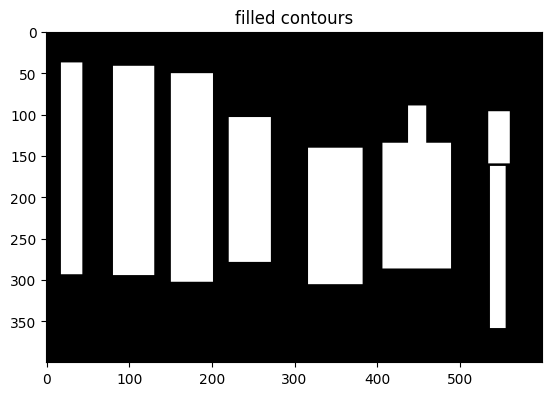

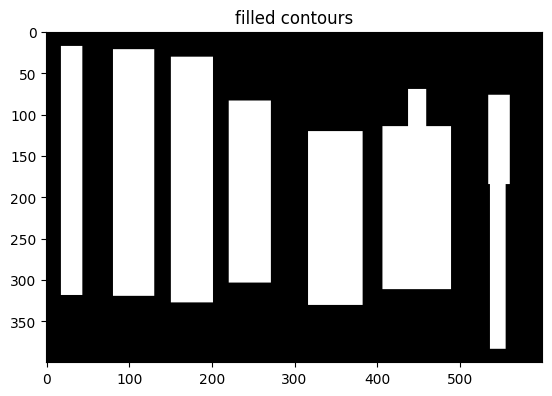

0.3142857142857143 13860
0.2318181818181818 11220
0.08469055374592833 7982
0.34297520661157027 20086
0.1717171717171717 15147
0.16778523489932887 14900
0.08637873754152824 7826


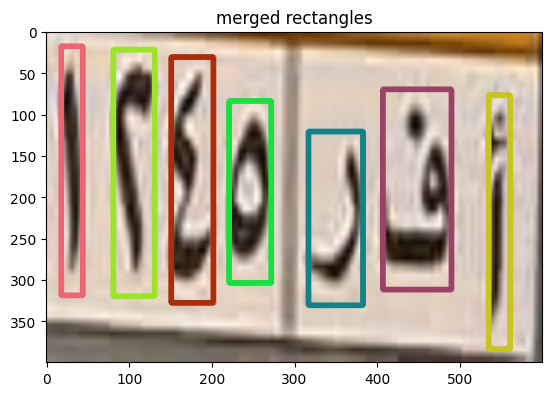

In [127]:
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#use 8 connectivity
cnts = imutils.grab_contours(cnts)
img_copy = img.copy()

for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    # random color
    color = np.random.randint(0, 255, size=(3,)).tolist()
    cv2.rectangle(img_copy, (x, y), (x + w, y + h), color, 2)
show_images([img_copy], ['contours'])
    
img_filled = np.zeros_like(img)
for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    aspect_ratio = w/h
    area = w*h
    if 0 < aspect_ratio < 1.4 and 500 < area < 50000:
        cv2.rectangle(img_filled, (x,y), (x+w,y+h), (255,255,255), thickness=cv2.FILLED)
show_images([img_filled], ['filled contours'])
img_filled = cv2.morphologyEx(img_filled, cv2.MORPH_DILATE,
                              cv2.getStructuringElement(cv2.MORPH_RECT, (1,10)),iterations=5)
img_filled = cv2.cvtColor(img_filled, cv2.COLOR_BGR2GRAY)
show_images([img_filled], ['filled contours'])

# find contours of filled image
cnts2 = cv2.findContours(img_filled, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts2 = imutils.grab_contours(cnts2)
rectangles = []
for c in cnts2:
    (x, y, w, h) = cv2.boundingRect(c)
    rectangles.append((x,y,w,h))
# rectangles = merge_vertical_rectangles(rectangles)

img_copy = img.copy()
image_area = img.shape[0]*img.shape[1]
img_width = img.shape[1]
final_rectangles = []
for r in rectangles:
    if r is not None:
        (x, y, w, h) = r
        # random color
        aspect_ratio = w/h
        area = w*h
        print(aspect_ratio,area)
        if w < 0.6*h and 1500 < area < image_area/5 and  img_width/50< w:
            final_rectangles.append(r)
            color = np.random.randint(0, 255, size=(3,)).tolist()
            cv2.rectangle(img_copy, (x, y), (x + w, y + h), color, 5)
show_images([img_copy], ['merged rectangles'])

In [128]:
import os
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from skimage import feature

#joblib is used to save the model
import joblib

In [129]:
def train_knn_model(data_set_path):
    # read images
    x_train = []
    y_train = []
    for dir in os.listdir(data_set_path):
        
        #label is directory name
        label = dir
        for file in os.listdir(os.path.join(data_set_path,dir)):
            if file.endswith('.png'):
                char_path = os.path.join(data_set_path,dir,file)
                # check if file exists
                if not os.path.isfile(char_path):
                    continue
                try:
                    img = io.imread(char_path)
                except:
                    continue
                if len(img.shape) == 3:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (20, 50))
                
                # extract hog features
                hog_img = feature.hog(img, orientations=9, pixels_per_cell=(8, 8),
                                      cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2-Hys")
                # hog_img = img.flatten()/255
                x_train.append(hog_img)
                y_train.append(label)
       
    data_set = np.array(x_train)
    labels = np.array(y_train)
    
    # split data
    X_train, X_test, y_train, y_test = train_test_split(data_set, labels, test_size=0.2, random_state=1)
    
    # train model
    model = neighbors.KNeighborsClassifier(n_neighbors=3)
    model.fit(X_train, y_train)
    
    # test model
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred))
    
    
    return model
    

In [130]:
def compute_threshold(data_set_path,knn_model):
    # read images
    x_train = []
    y_train = []
    for dir in os.listdir(data_set_path):
        #label is directory name
        label = dir
        for file in os.listdir(os.path.join(data_set_path,dir)):
                if file.endswith('.png'):
                    char_path = os.path.join(data_set_path,dir,file)
                    # check if file exists
                    if not os.path.isfile(char_path):
                        continue
                    try:
                        img = io.imread(char_path)
                    except:
                        continue
                    if len(img.shape) == 3:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    img = cv2.resize(img, (20, 50))
                    
                    #extract hog features
                    hog_img = feature.hog(img, orientations=9, pixels_per_cell=(8, 8),
                                        cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2-Hys")
                    x_train.append(hog_img)
                    y_train.append(label)
       
    data_set = np.array(x_train)
    labels = np.array(y_train)
    
    distances, _ = knn_model.kneighbors(data_set)
    
    threshold = np.mean(distances) + 2*np.std(distances)
    
    return threshold

In [131]:
model = train_knn_model('Chars_DataSet')
joblib.dump(model, 'model_1.pkl')

              precision    recall  f1-score   support

           أ       0.99      0.99      0.99        75
           ب       1.00      1.00      1.00        29
           ج       1.00      1.00      1.00        39
           د       0.98      1.00      0.99        40
           ر       0.96      0.99      0.97        67
           س       0.99      0.97      0.98        75
           ص       0.96      0.96      0.96        28
           ط       0.96      0.96      0.96        24
           ع       1.00      1.00      1.00        61
           ف       1.00      1.00      1.00        39
           ق       1.00      0.97      0.98        32
           ل       1.00      0.97      0.99        38
           م       0.98      1.00      0.99       106
           ن       0.95      1.00      0.97        38
           و       1.00      0.91      0.95        34
           ى       1.00      1.00      1.00        43
           ١       0.99      1.00      0.99       152
           ٢       1.00    

['model_1.pkl']

In [132]:
knn_model = joblib.load('model_1.pkl')

In [133]:
# model_threshold = compute_threshold('Chars_DataSet',knn_model)

In [134]:
# print(model_threshold)

7
535
1.1477839692729337
1.4466136091702204
1.2468756159536571
['أ']


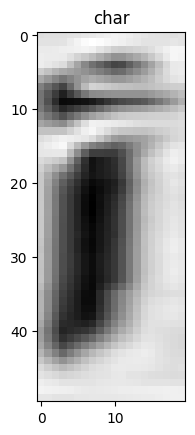

407
0.860577123829241
1.4466136091702204
0.9293905961498271
['ف']


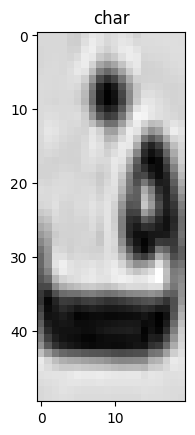

317
0.6821369207443658
1.4466136091702204
0.7858052017826029
['ر']


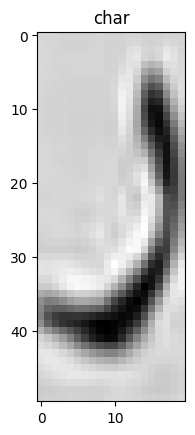

221
1.1431819760192008
1.4466136091702204
1.1485119255920537
['٥']


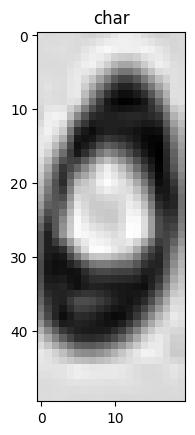

151
0.7793832834900077
1.4466136091702204
0.8901013949061225
['٤']


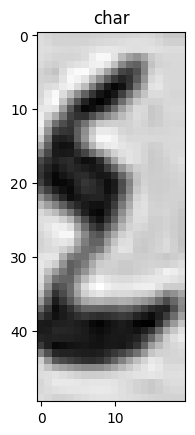

81
0.6989056729245411
1.4466136091702204
0.7044009136265217
['٢']


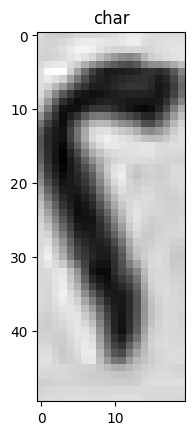

18
1.0400181513891305
1.4466136091702204
1.0550174076918557
['١']


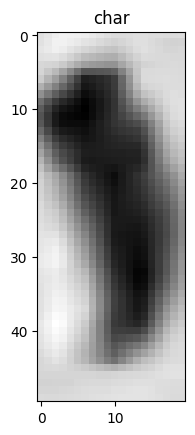

أفر٥٤٢١


In [135]:
final_rectangles = sorted(final_rectangles, key=lambda x: -x[0])
license_plate = ''
print(len(final_rectangles))
for rectangle in final_rectangles:
    x, y, w, h = rectangle
    char_img = img[y:y+h, x:x+w]
    char_img = cv2.cvtColor(char_img, cv2.COLOR_BGR2GRAY)
    char_img = cv2.resize(char_img, (20, 50))
    #adaptive thresholding
    hog_img = feature.hog(char_img, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2-Hys")

    char = knn_model.predict([hog_img])
    print(x)
    distances, _ = knn_model.kneighbors([hog_img])
    nearest_distance = distances[0][0]
    print(nearest_distance)
    if nearest_distance > model_threshold:
        continue
    print(model_threshold)
    print(np.mean(distances))
    print(char)
    license_plate += char[0]
    show_images([char_img], ['char'])
    
#reverse license plate
print(license_plate)